# 0. 환경설정 및 데이터 업로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import xgboost as xgb 

import graphviz
from sklearn.tree import export_graphviz
from plotnine import *
import plotnine

from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
# 학습용 데이터
model_data = pd.read_csv('./data/KOTRA_학습용_데이터.csv') 
model_data.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)

# 예측용 데이터
predict_data = pd.read_csv('./data/KOTRA_예측용_데이터.csv')
predict_data.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)

# 원본 데이터 로드
raw_data = pd.read_csv('./data/공모전데이터_분석용_KOTRA_0525.csv')
raw_data.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)
submission = pd.read_csv('./data/공모전데이터_예측용_KOTRA_0525.csv')
submission.drop(['UNC_YEAR','COUNTRYCD','NY_GDP_MKTP_CD_1Y'], axis = 1, inplace = True)

# 1. 분석용 데이터 전처리

### 1.1) 로그(Log) 변환

In [3]:
def Log_scale(raw_data, model_data):
    raw_df = raw_data.copy()
    model_df = model_data.copy()
    
    skewness = raw_df.drop(['COUNTRYNM','HSCD'], axis = 1).apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness>1].index
    print('로그(Log)변환을 적용할 변수명 : ', skew_feats.to_list())
    
    model_df[skew_feats] = np.log1p(model_df[skew_feats])
    
    return model_df

model_data = Log_scale(raw_data, model_data)
predict_data = Log_scale(submission, predict_data)

model_data.shape, predict_data.shape

로그(Log)변환을 적용할 변수명 :  ['KR_TRADE_HSCD_COUNTRYCD', 'TRADE_HSCD_COUNTRYCD', 'TARIFF_AVG', 'TRADE_HSCD', 'NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'TRADE_COUNTRYCD']
로그(Log)변환을 적용할 변수명 :  ['TRADE_HSCD_COUNTRYCD', 'TARIFF_AVG', 'TRADE_HSCD', 'NY_GDP_MKTP_CD', 'SP_POP_TOTL', 'PA_NUS_FCRF', 'TRADE_COUNTRYCD']


((21189, 51), (21189, 51))

### 1.2) 정규화(MinMaxScaler) 스케일링

In [4]:
def MINMAX_SC(raw_data, model_data):
    raw_df = raw_data.copy()
    df = model_data.copy()
    
    # 카테고리형 제외한 Minmax 정규화
    skewness = raw_df.drop(['COUNTRYNM','HSCD'], axis = 1).apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness>1].index
    
    numerical_feats = df.dtypes[df.dtypes != "object"].index.tolist()
    numerical_feats.remove('HSCD')
    numerical_feats.remove('KR_TRADE_HSCD_COUNTRYCD')
    
    numerical_feats = list(set(numerical_feats) - set(skew_feats))
    df[numerical_feats] = MinMaxScaler().fit_transform(df[numerical_feats])
    
    return df
    
model_data = MINMAX_SC(raw_data, model_data) # model_data
predict_data = MINMAX_SC(submission, predict_data)
model_data.shape, predict_data.shape

((21189, 51), (21189, 51))

### 1.3) 레이블 인코딩(LabelEncoding)

In [5]:
def Label_enc(data):
    df = data.copy()
    
    # HSCD, COUNTRYNM, Category_L, Category_M, Category_S 5개 변수에 대해 적용
    df['HSCD'] = LabelEncoder().fit_transform(df['HSCD'].values)
    df['COUNTRYNM'] = LabelEncoder().fit_transform(df['COUNTRYNM'].values)
    df['Category_L'] = LabelEncoder().fit_transform(df['Category_L'].values)
    df['Category_M'] = LabelEncoder().fit_transform(df['Category_M'].values)
    df['Category_S'] = LabelEncoder().fit_transform(df['Category_S'].values)
    
    return df

model_data_label = Label_enc(model_data)
predict_data_label = Label_enc(predict_data)

model_data_label.shape, predict_data_label.shape

((21189, 51), (21189, 51))

### 1.4) 원핫 인코딩(One-hotEncoding)

In [6]:
def Onehot_enc(data):
    df = data.copy()
    
    # HSCD, COUNTRYNM, Category_L, Category_M, Category_S 5개 변수에 대해 적용
    object_col = ['HSCD', 'COUNTRYNM', 'Category_L', 'Category_M', 'Category_S']

    enc = OneHotEncoder()
    enc.fit(df.loc[:,object_col])
    onehot_df = pd.DataFrame(enc.transform(df.loc[:,object_col]).toarray(), columns = enc.get_feature_names(object_col))
    
    df.drop(object_col, axis=1, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)   
    
    return df

model_data_onehot = Onehot_enc(model_data)
predict_data_onehot = Onehot_enc(predict_data)

model_data_onehot.shape, predict_data_onehot.shape

((21189, 649), (21189, 649))

### 1.5) 이상치(Outlier) 확인

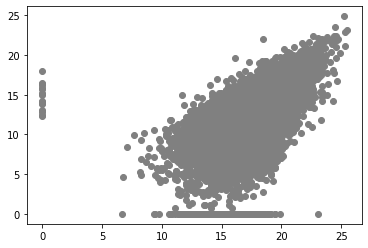

In [7]:
plt.scatter(x = model_data_label['TRADE_HSCD_COUNTRYCD'], y = model_data_label['KR_TRADE_HSCD_COUNTRYCD'], color = 'gray')
plt.show()

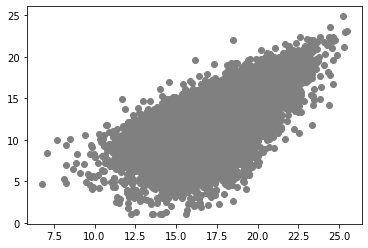

In [8]:
def Outlier_remove(label_data, onehot_data):
    df1 = label_data.copy()
    df2 = onehot_data.copy()
    
    df1 = df1[df1['KR_TRADE_HSCD_COUNTRYCD'] > 1]
    df1 = df1[df1['TRADE_HSCD_COUNTRYCD'] > 1]
    df1.reset_index(drop=True, inplace=True)

    df2 = df2[df2['KR_TRADE_HSCD_COUNTRYCD'] > 1]
    df2 = df2[df2['TRADE_HSCD_COUNTRYCD'] > 1]
    df2.reset_index(drop=True, inplace=True)
    
    return df1, df2

model_data_label, model_data_onehot = Outlier_remove(model_data_label, model_data_onehot)

plt.scatter(x = model_data_label['TRADE_HSCD_COUNTRYCD'], y = model_data_label['KR_TRADE_HSCD_COUNTRYCD'], color = 'gray')
plt.show()

### 1.6) 상관계수(Correlation) 확인

In [9]:
# 상관계수 데이터 불러오기
cor_data = model_data_label.copy()
cor_data.drop(['HSCD', 'COUNTRYNM'], axis = 1, inplace = True)

# 절대값 기준으로 상관계수 검정
corr_matrix = cor_data.corr().abs()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# 0.8 강한 상관계수 값을 보이는 변수들만 추출
corr_rel_check = (corr_matrix > 0.8).sum()-1 
corr_remove = pd.DataFrame(corr_rel_check[corr_rel_check > 0]).T

# 상관계수 다시 생성
corr_remove = cor_data[corr_remove.columns.to_list()].corr().abs()
mask = np.zeros_like(corr_remove, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

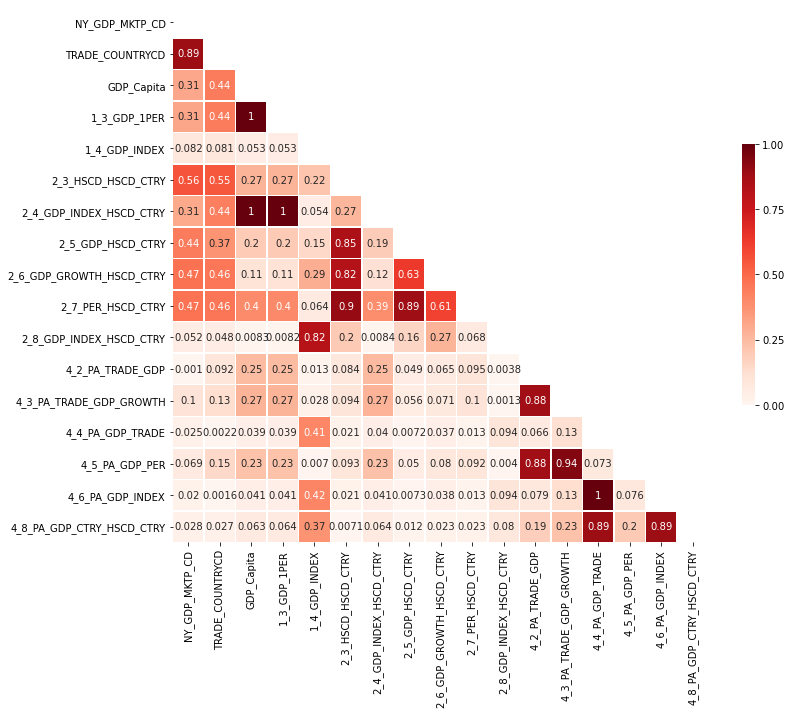

In [10]:
f, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(corr_remove,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'Reds', #
                      cbar_kws = {'shrink': .4,
                                'ticks' : [0 , 0.25, 0.5, 0.75 , 1]},
                      vmin = 0,
                      vmax = 1,
                      annot = True
                     )
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [11]:
corr_remove.columns

Index(['NY_GDP_MKTP_CD', 'TRADE_COUNTRYCD', 'GDP_Capita', '1_3_GDP_1PER',
       '1_4_GDP_INDEX', '2_3_HSCD_HSCD_CTRY', '2_4_GDP_INDEX_HSCD_CTRY',
       '2_5_GDP_HSCD_CTRY', '2_6_GDP_GROWTH_HSCD_CTRY', '2_7_PER_HSCD_CTRY',
       '2_8_GDP_INDEX_HSCD_CTRY', '4_2_PA_TRADE_GDP',
       '4_3_PA_TRADE_GDP_GROWTH', '4_4_PA_GDP_TRADE', '4_5_PA_GDP_PER',
       '4_6_PA_GDP_INDEX', '4_8_PA_GDP_CTRY_HSCD_CTRY'],
      dtype='object')

In [12]:
def corr_remove(data):
    df = data.copy()
    
    df.drop(['NY_GDP_MKTP_CD', '1_3_GDP_1PER',
             '2_3_HSCD_HSCD_CTRY', '2_4_GDP_INDEX_HSCD_CTRY', '2_7_PER_HSCD_CTRY', '2_8_GDP_INDEX_HSCD_CTRY',
             '4_3_PA_TRADE_GDP_GROWTH', '4_4_PA_GDP_TRADE', '4_5_PA_GDP_PER', '4_8_PA_GDP_CTRY_HSCD_CTRY'], 
              axis =1 , inplace = True)
    
    return df    

model_data_label = corr_remove(model_data_label)
model_data_onehot = corr_remove(model_data_onehot)

predict_data_label = corr_remove(predict_data_label)
predict_data_onehot = corr_remove(predict_data_onehot)

#### 최종 데이터 셋 구성 

In [13]:
model_data_label.shape, model_data_onehot.shape, predict_data_label.shape, predict_data_onehot.shape

((20827, 41), (20827, 639), (21189, 41), (21189, 639))

# 2. 모델링(Modeling)

#### 회귀 평가 함수 생성

In [14]:
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### 2.1) 회귀기반 모델 제안

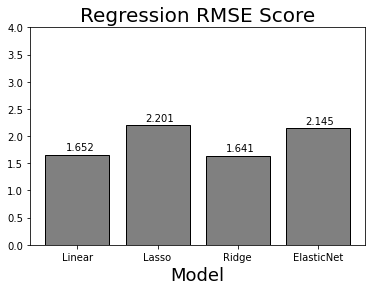

In [15]:
# X데이터와 Y데이터 분할
X_data_oh = model_data_onehot.drop(['KR_TRADE_HSCD_COUNTRYCD'], axis=1,inplace=False)
y_data_oh = model_data_onehot['KR_TRADE_HSCD_COUNTRYCD']

# 학습비율 8:2로 train과 test셋 분할
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_data_oh, y_data_oh, test_size=0.20, random_state = 42)

# 선형 모델 3가지와 Tree & Boosting 기반 모델 3가지를 dict으로 저장
models = {
    'Linear' :LinearRegression().fit(X_train_oh, y_train_oh),
    'Lasso': Lasso().fit(X_train_oh, y_train_oh),
    'Ridge': Ridge().fit(X_train_oh, y_train_oh),
    'ElasticNet': ElasticNet().fit(X_train_oh, y_train_oh)
}

# 테스트 데이터셋(20%)를 예측
Linear_model = models['Linear'].predict(X_test_oh)
Lasso_model = models['Lasso'].predict(X_test_oh)
Ridge_model = models['Ridge'].predict(X_test_oh)
Elastic_model = models['ElasticNet'].predict(X_test_oh)


# 테스트 데이터 셋의 RMSE 계산
rmse_score = [RMSE(Linear_model, y_test_oh),
               RMSE(Lasso_model, y_test_oh),
               RMSE(Ridge_model, y_test_oh),
               RMSE(Elastic_model, y_test_oh)]

x_lab = ['Linear', 'Lasso', 'Ridge', 'ElasticNet']

plt.bar(x_lab, rmse_score, color = 'gray', edgecolor='black')
plt.title('Regression RMSE Score', fontsize=20)
plt.xlabel('Model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0,4)

# 막대그래프 위에 값을 표시
for i, v in enumerate(rmse_score):
    plt.text(i-0.15, v + 0.08, str(np.round(v,3))) 
    
plt.show()

### 2.2) 트리 기반 부스팅 모델 제안

Learning rate set to 0.370564
0:	learn: 2.4611363	total: 164ms	remaining: 16.2s
1:	learn: 2.2345553	total: 191ms	remaining: 9.37s
2:	learn: 2.1020947	total: 207ms	remaining: 6.7s
3:	learn: 2.0282155	total: 216ms	remaining: 5.19s
4:	learn: 1.9894814	total: 225ms	remaining: 4.27s
5:	learn: 1.9613237	total: 233ms	remaining: 3.65s
6:	learn: 1.9428213	total: 241ms	remaining: 3.2s
7:	learn: 1.9221232	total: 249ms	remaining: 2.87s
8:	learn: 1.9094965	total: 258ms	remaining: 2.6s
9:	learn: 1.8990171	total: 265ms	remaining: 2.39s
10:	learn: 1.8855774	total: 273ms	remaining: 2.21s
11:	learn: 1.8737683	total: 281ms	remaining: 2.06s
12:	learn: 1.8635251	total: 289ms	remaining: 1.93s
13:	learn: 1.8548912	total: 297ms	remaining: 1.82s
14:	learn: 1.8481583	total: 305ms	remaining: 1.73s
15:	learn: 1.8453740	total: 313ms	remaining: 1.64s
16:	learn: 1.8358344	total: 321ms	remaining: 1.57s
17:	learn: 1.8313339	total: 329ms	remaining: 1.5s
18:	learn: 1.8251256	total: 336ms	remaining: 1.43s
19:	learn: 1.82

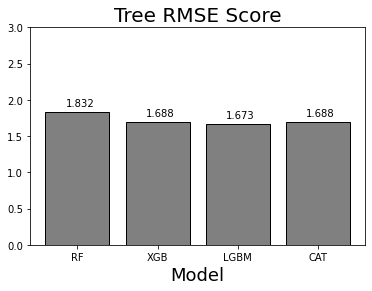

In [16]:
# X데이터와 Y데이터 분할
X_data_lab = model_data_label.drop(['KR_TRADE_HSCD_COUNTRYCD'], axis=1,inplace=False)
y_data_lab = model_data_label['KR_TRADE_HSCD_COUNTRYCD']

# 학습비율 8:2로 train과 test셋 분할
X_train_lab, X_test_lab, y_train_lab, y_test_lab = train_test_split(X_data_lab, y_data_lab, test_size=0.20, random_state = 42)

# 선형 모델 3가지와 Tree & Boosting 기반 모델 3가지를 dict으로 저장
models = {
    'RF' : RandomForestRegressor(n_estimators = 100, random_state=42, n_jobs=-1).fit(X_train_lab, y_train_lab),
    'XGB' : xgb.XGBRegressor(n_estimators = 100, random_state=42, n_jobs=-1).fit(X_train_lab, y_train_lab),
    'LGBM' : LGBMRegressor(n_estimators = 100, random_state=42, n_jobs=-1).fit(X_train_lab, y_train_lab),
    'CAT' : CatBoostRegressor(n_estimators = 100, random_state=42).fit(X_train_lab, y_train_lab)
}

# 테스트 데이터셋(20%)를 예측
RF_model = models['RF'].predict(X_test_lab)
XGB_model = models['XGB'].predict(X_test_lab)
LGBM_model = models['LGBM'].predict(X_test_lab)
CAT_model = models['CAT'].predict(X_test_lab)

# 테스트 데이터 셋의 RMSE 계산
rmse_score = [ RMSE(RF_model, y_test_lab),
               RMSE(XGB_model, y_test_lab),
               RMSE(LGBM_model, y_test_lab),
               RMSE(CAT_model, y_test_lab)]

x_lab = ['RF', 'XGB', 'LGBM','CAT']

plt.bar(x_lab, rmse_score, color = 'gray', edgecolor='black') # 단위 :: 백만원
plt.title('Tree RMSE Score', fontsize=20)
plt.xlabel('Model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0,3)

# 막대그래프 위에 값을 표시
for i, v in enumerate(rmse_score):
    plt.text(i-0.15, v + 0.08, str(np.round(v,3))) 
    
plt.show()

### 2.3) 릿지 회귀(Ridge regression model)

#### 하이퍼 파라미터 최적화(Grid SearchCV)

In [17]:
ridge_params = {'alpha':np.logspace(-4, 1, 20)}
print(GridSearchCV(Ridge(), param_grid=ridge_params, cv = 5).fit(X_data_oh, y_data_oh).best_estimator_)

Ridge(alpha=10.0)


#### 모델 학습 및 예측

In [18]:
seed = 84
n_fold = 10
Ridge_models={}

kf = KFold(n_splits=10, shuffle=True, random_state=84)

folds=[]
for train_idx, valid_idx in kf.split(X_train_oh):
    folds.append((train_idx, valid_idx))


for fold in range(10):
    # 데이터 분할
    train_idx, valid_idx = folds[fold] 
    X_train, X_valid, y_train, y_valid = model_data_onehot.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[train_idx].values,\
                                         model_data_onehot.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[valid_idx].values,\
                                         model_data_onehot['KR_TRADE_HSCD_COUNTRYCD'][train_idx].values,\
                                         model_data_onehot['KR_TRADE_HSCD_COUNTRYCD'][valid_idx].values   

      
    # 모델 
    ridge_params = {'alpha' : 10, 'random_state' : 42}
    
    Ridge_model = Ridge(**ridge_params).fit(X_train, y_train)
    score = Ridge_model.predict(X_valid)
    print(fold+1 , ': validation-rmse : ',RMSE(score, y_valid))
    Ridge_models[fold]=Ridge_model
    
# OOF(Out of Fold) 검증
Ridge_result = X_test_oh.copy()
Ridge_result['rslt'] = 0

for fold in range(10):
    Ridge_result['rslt'] += Ridge_models[fold].predict(X_test_oh) / 10
    
print('# Total RMSE : ', RMSE(Ridge_result['rslt'], y_test_oh))

1 : validation-rmse :  1.675431600476867
2 : validation-rmse :  1.661483508554246
3 : validation-rmse :  1.6813840549979941
4 : validation-rmse :  1.6514742965199787
5 : validation-rmse :  1.7151215892593104
6 : validation-rmse :  1.6657122736375534
7 : validation-rmse :  1.7554693452822543
8 : validation-rmse :  1.5806292783008562
9 : validation-rmse :  1.743633355240675
10 : validation-rmse :  1.6495424006155148
# Total RMSE :  1.6686086300489866


### 2.4) LGBM(Light gradient boosting model)

#### 하이퍼 파라미터 최적화(BayesianOptimization)

In [19]:
# 하이퍼 파라미터 튜닝 데이터 분리 및 파라미터 설정
X_train, X_test, y_train, y_test = train_test_split(X_train_lab, y_train_lab, test_size=0.20, random_state = 42)

lgbm_params = {
    'max_depth': (12, 18),          # 16
    'num_leaves': (130, 160),       # 160
    'min_child_samples': (10, 20),  # 13
    'colsample_bytree': (0.6, 0.8), # 0.65
    'subsample': (0.6, 0.8),        # 0.65
    'reg_lambda' : (3, 20)          # 10  
}

# LGBM 모델
def lgb_rmse_eval(max_depth, num_leaves, min_child_samples, subsample, colsample_bytree, reg_lambda):
    params = {
        "n_estimators":1000, "learning_rate":0.05,
        'max_depth': int(round(max_depth)),
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0)
    }
    lgb_model = LGBMRegressor(**params, random_state=84)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'neg_mean_squared_error', verbose= 100, 
                early_stopping_rounds= 50)
    valid_prob = lgb_model.predict(X_test_lab)
    RMSE_Value = RMSE(valid_prob, y_test_lab) * -1 # 평가지표 반환을 위한 -1 곱

    return RMSE_Value   

# BayesianOptimization 실행
lgbBO = BayesianOptimization(lgb_rmse_eval,lgbm_params , random_state=42)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... | max_depth | min_ch... | num_le... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.60864	valid_1's l2: 3.0035
[200]	training's l2: 0.993289	valid_1's l2: 2.90605
Early stopping, best iteration is:
[202]	training's l2: 0.984601	valid_1's l2: 2.90542
|  1        | -1.647    |  0.6749   |  17.7     |  17.32    |  148.0    |  5.652    |  0.6312   |
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.56698	valid_1's l2: 3.01813
[200]	training's l2: 0.950924	valid_1's l2: 2.93595
Early stopping, best iteration is:
[249]	training's l2: 0.782132	valid_1's l2: 2.9194
|  2        | -1.653    |  0.6116   |  17.2     |  16.01    |  151.2    |  3.35     |  0.794    |
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.72053	valid_1's l2: 3.02

Early stopping, best iteration is:
[220]	training's l2: 1.13296	valid_1's l2: 2.92144
|  19       | -1.649    |  0.7299   |  17.22    |  15.59    |  139.9    |  19.16    |  0.7114   |
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.64625	valid_1's l2: 3.03654
[200]	training's l2: 1.07683	valid_1's l2: 2.9529
[300]	training's l2: 0.771074	valid_1's l2: 2.9456
Early stopping, best iteration is:
[272]	training's l2: 0.848533	valid_1's l2: 2.94155
|  20       | -1.651    |  0.7048   |  12.84    |  14.77    |  146.0    |  4.887    |  0.6596   |
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 1.81713	valid_1's l2: 3.06617
[200]	training's l2: 1.22378	valid_1's l2: 2.92372
[300]	training's l2: 0.92334	valid_1's l2: 2.90649
Early stopping, best iteration is:
[289]	training's l2: 0.945526	valid_1's l2: 2.90543
|  21       | -1.648    |  0.6452   |  12.63    |  11.58    |  146.1    |  16.47    |  0.7506   |
Training until vali

In [20]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

{'target': -1.6421416044421115, 'params': {'colsample_bytree': 0.6248410121203073, 'max_depth': 16.276297920073674, 'min_child_samples': 17.406878238056148, 'num_leaves': 134.69246193169434, 'reg_lambda': 13.774919081881825, 'subsample': 0.7769778159208988}}


#### 모델 학습 및 예측

In [21]:
seed = 84
n_fold = 10

kf = KFold(n_splits=10, shuffle=True, random_state=84)

folds=[]
for train_idx, valid_idx in kf.split(X_train_lab):
    folds.append((train_idx, valid_idx))

lgb_models={}
for fold in range(10):
    print(f'===================================={fold+1}============================================')
    # 데이터 분할
    train_idx, valid_idx = folds[fold] 
    X_train, X_valid, y_train, y_valid = model_data_label.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[train_idx].values,\
                                         model_data_label.drop(['KR_TRADE_HSCD_COUNTRYCD'],axis=1).iloc[valid_idx].values,\
                                         model_data_label['KR_TRADE_HSCD_COUNTRYCD'][train_idx].values,\
                                         model_data_label['KR_TRADE_HSCD_COUNTRYCD'][valid_idx].values   

    params_lgb = {
            "n_estimators": 1000,
            "random_state": 84, 
            "verbosity": -1,
            "learning_rate": 0.05,
            "max_depth": 16,       
            'min_child_samples': 15,
            'num_leaves': 150,
            "subsample" : 0.65,
            "colsample_bytree" : 0.65
        }
 
    # 모델
    model_lgb = LGBMRegressor(**params_lgb)
    model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=100, verbose=100)
    
    
    lgb_models[fold]=model_lgb
    print(f'================================================================================\n\n')

# OOF(Out of Fold) 검증
lgbm_result = X_test_lab.copy()
lgbm_result['rslt'] = 0

for fold in range(10):
    lgbm_result['rslt'] += lgb_models[fold].predict(X_test_lab)/10 

print('# Total RMSE : ', RMSE(lgbm_result['rslt'], y_test_lab))

====================================1============================================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.45131	valid_1's l2: 2.83474
[200]	training's l2: 0.892503	valid_1's l2: 2.76741
Early stopping, best iteration is:
[193]	training's l2: 0.919608	valid_1's l2: 2.76473


====================================2============================================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.46291	valid_1's l2: 2.75979
[200]	training's l2: 0.915679	valid_1's l2: 2.6875
Early stopping, best iteration is:
[168]	training's l2: 1.03223	valid_1's l2: 2.68473


====================================3============================================
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.46483	valid_1's l2: 2.78828
[200]	training's l2: 0.901886	valid_1's l2: 2.69001
[300]	training's l2: 0.612409	valid_1's l2: 2.6894
Early stopping, best iteration i

### 2.5) Catboost(Categorical boosting model)

#### 하이퍼 파라미터 최적화 : Catboost의 경우 하이퍼파라미터를 조정하지 않는 경우가 가장 높은 성능보였음.

#### 모델 학습 및 예측

In [22]:
seed = 84
n_fold = 10

X_train_lab.reset_index(drop=True, inplace=True)
X_test_lab.reset_index(drop=True, inplace=True)
y_train_lab.reset_index(drop=True, inplace=True)
y_test_lab.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=10, shuffle=True, random_state=84)

folds=[]
for train_idx, valid_idx in kf.split(X_train_lab):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X_train_lab.shape[0]))
cat_pred_test = np.zeros((X_test_lab.shape[0]))
cat_cols = ['HSCD', 'COUNTRYNM', 'Category_L', 'Category_M' ,'Category_S']

cat_models={}
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold+1} -----------------\n')

    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X_train_lab.iloc[train_idx], X_train_lab.iloc[valid_idx],\
                                         y_train_lab[train_idx], y_train_lab[valid_idx]

    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostRegressor(random_state = 84)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
  
    cat_pred[valid_idx] = model_cat.predict(X_valid)
    cat_pred_test += model_cat.predict(X_test_lab) / n_fold
    print(f'CV RMSE Score: {RMSE(cat_pred[valid_idx],y_valid):.6f}')
    
    cat_models[fold]=model_cat
    
# OOF(Out of Fold) 검증
cat_result = X_test_lab.copy()
cat_result['rslt'] = 0

for fold in range(10):
    cat_result['rslt'] += cat_models[fold].predict(X_test_lab)/10
    
print(f'\RMSE Loss: {RMSE(cat_pred_test, y_test_lab):.6f}') 


----------------- Fold 1 -----------------

Learning rate set to 0.076866
0:	learn: 2.8013163	test: 2.7951209	best: 2.7951209 (0)	total: 46.9ms	remaining: 46.9s
100:	learn: 1.7341920	test: 1.7736610	best: 1.7736610 (100)	total: 4.5s	remaining: 40.1s
200:	learn: 1.6535589	test: 1.7305222	best: 1.7305222 (200)	total: 8.92s	remaining: 35.5s
300:	learn: 1.6002094	test: 1.7102728	best: 1.7101431 (299)	total: 13.5s	remaining: 31.3s
400:	learn: 1.5573001	test: 1.6984282	best: 1.6984282 (400)	total: 18.2s	remaining: 27.1s
500:	learn: 1.5190171	test: 1.6889915	best: 1.6889381 (499)	total: 22.5s	remaining: 22.4s
600:	learn: 1.4871694	test: 1.6865068	best: 1.6862749 (595)	total: 26.9s	remaining: 17.8s
700:	learn: 1.4534016	test: 1.6835123	best: 1.6835123 (700)	total: 31.4s	remaining: 13.4s
800:	learn: 1.4261493	test: 1.6792188	best: 1.6786176 (779)	total: 35.7s	remaining: 8.87s
900:	learn: 1.3999614	test: 1.6746323	best: 1.6741876 (893)	total: 40.1s	remaining: 4.41s
Stopped by overfitting detect

600:	learn: 1.4970321	test: 1.5666515	best: 1.5661053 (589)	total: 27.8s	remaining: 18.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.565489152
bestIteration = 628

Shrink model to first 629 iterations.
CV RMSE Score: 1.565489

----------------- Fold 10 -----------------

Learning rate set to 0.076867
0:	learn: 2.8079771	test: 2.8588503	best: 2.8588503 (0)	total: 42.9ms	remaining: 42.9s
100:	learn: 1.7286790	test: 1.7204916	best: 1.7204916 (100)	total: 4.82s	remaining: 42.9s
200:	learn: 1.6467384	test: 1.6822931	best: 1.6820813 (193)	total: 9.69s	remaining: 38.5s
300:	learn: 1.5910242	test: 1.6655444	best: 1.6647898 (298)	total: 14.4s	remaining: 33.3s
400:	learn: 1.5437935	test: 1.6557162	best: 1.6557162 (400)	total: 18.9s	remaining: 28.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.653312763
bestIteration = 422

Shrink model to first 423 iterations.
CV RMSE Score: 1.653313
\RMSE Loss: 1.593609


# 3. 모형 해석

### 3.1) 검증결과 지표 비교 및 그래프

#### 검증결과 지표(기존)

In [23]:
# 데이터 프레임 형성
rslt_data = pd.DataFrame({'Ridge' : Ridge_result['rslt'].values,
                          'LGBM' : lgbm_result['rslt'].values, 
                          'Catboost' : cat_result['rslt'] ,
                          'Actual_log' : y_test_lab})

rslt_data['Ensemble_AVG'] = (rslt_data['Ridge'] + rslt_data['LGBM'] + rslt_data['Catboost']) / 3
rslt_data['Actual_value'] = np.expm1(rslt_data['Actual_log'])
rslt_data['Predict_value'] = np.expm1(rslt_data['Ensemble_AVG'])

# 결과 확인
print('Total RMSE Loss : ', RMSE(rslt_data['Ensemble_AVG'], rslt_data['Actual_log']))
rslt_data.sample(5, random_state = 42)

Total RMSE Loss :  1.4422380509481196


,Ridge,LGBM,Catboost,Actual_log,Ensemble_AVG,Actual_value,Predict_value
1945,14.37411,14.73342,14.52970,15.11129,14.54574,3653845.00000,2075562.34199
238,21.74108,21.79905,20.99335,22.12470,21.51116,4061035672.00000,2198756175.03604
761,9.73672,9.61871,10.04507,9.15377,9.80017,9449.00000,18035.72757
330,12.08581,12.78606,12.57847,12.35819,12.48345,232859.00000,263931.39397
3668,14.50308,14.57387,14.84021,14.46261,14.63906,1909995.00000,2278562.07604


#### 스태킹 검증결과 지표 (Linear Regression Model)

In [24]:
rslt_data = pd.DataFrame({'Ridge' : Ridge_result['rslt'].values,
                          'LGBM' : lgbm_result['rslt'].values, 
                          'Catboost' : cat_result['rslt'] ,
                          'Actual_log' : y_test_lab})

# 각 모델 별 학습
stack_x = rslt_data[['Ridge','LGBM','Catboost']].values
stack_y = rslt_data['Actual_log']

stack_model = LinearRegression().fit(stack_x, stack_y)  
stack_score = stack_model.predict(stack_x)

rslt_data['Stacking_log'] = stack_score
rslt_data['Actual_value'] = np.expm1(rslt_data['Actual_log'])
rslt_data['Predict_value'] = np.expm1(rslt_data['Stacking_log'])

print("스태킹 앙상블 모델(Linear Model Coef)", stack_model.coef_)
print('Total RMSE Loss : ',RMSE(stack_score, stack_y))

rslt_data.sample(5, random_state = 42)

스태킹 앙상블 모델(Linear Model Coef) [-0.47596448  1.46017841  0.03315393]
Total RMSE Loss :  1.152323158577552


,Ridge,LGBM,Catboost,Actual_log,Stacking_log,Actual_value,Predict_value
1945,14.37411,14.73342,14.52970,15.11129,14.91872,3653845.00000,3013834.31114
238,21.74108,21.79905,20.99335,22.12470,21.94367,4061035672.00000,3388571338.03874
761,9.73672,9.61871,10.04507,9.15377,9.50888,9449.00000,13477.91637
330,12.08581,12.78606,12.57847,12.35819,13.09969,232859.00000,488787.92820
3668,14.50308,14.57387,14.84021,14.46261,14.63465,1909995.00000,2268552.37418


In [25]:
# 스태킹 앙상블 검증(Cross validation score = 5)
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
neg_mse_scores = cross_val_score(lr, stack_x, stack_y, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [-1.21 -1.34 -1.38 -1.23 -1.51]
 5 교차 검증의 개별 RMSE scores :  [1.1  1.16 1.17 1.11 1.23]
 5 교차 검증의 평균 RMSE : 1.153 


#### 결과물 확인 및 제출 

In [26]:
# 예측용 데이터 생성
submission_onehot = predict_data_onehot.drop('KR_TRADE_HSCD_COUNTRYCD', axis =1, inplace = False)
submission_label = predict_data_label.drop('KR_TRADE_HSCD_COUNTRYCD', axis =1, inplace = False)

# 빈 데이터프레임 생성
predict_rslt = pd.DataFrame(np.zeros((submission.shape[0],3)), columns = ['Ridge', 'LGBM', 'Catboost'])

# OOF(Out of Fold) 방식 예측
for fold in range(10):
    predict_rslt['Ridge'] += Ridge_models[fold].predict(submission_onehot) / 10
for fold in range(10):
    predict_rslt['LGBM'] += lgb_models[fold].predict(submission_label)/10 
for fold in range(10):
    predict_rslt['Catboost'] += cat_models[fold].predict(submission_label)/10 
    
# 최종 예측값에 대한 평균
# predict_rslt['Ensemble_AVG'] = (predict_rslt['Ridge'] + predict_rslt['LGBM'] + predict_rslt['Catboost']) / 3

# 최종 예측값에 스태킹 앙상블
real_x = predict_rslt[['Ridge','LGBM','Catboost']].values
real_score = stack_model.predict(real_x)

predict_rslt['Stacking_log'] = real_score
predict_rslt['Predict_value'] = np.expm1(predict_rslt['Stacking_log'])
predict_rslt.sample(5, random_state = 42)

,Ridge,LGBM,Catboost,Stacking_log,Predict_value
1056,10.99135,11.38148,11.25160,11.52567,101282.10493
9559,15.87151,15.80533,16.57815,15.83910,7565411.87119
4794,10.32456,12.15380,11.53694,12.98024,433753.98933
9912,13.95311,14.47519,14.64844,14.74597,2535677.41993
15580,15.33825,15.04767,15.69466,14.95730,3132382.38561


In [27]:
submission_to_file = pd.read_csv('./data/공모전데이터_예측용_KOTRA_0525.csv')
submission_to_file['KR_TRADE_HSCD_COUNTRYCD'] = predict_rslt['Predict_value']
submission_to_file.head()

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2018,190590,12,Algeria,42196119729,22234640370.00000,27.00000,3735.04739,175405660377,170163165961,42228429.00000,100.69143,46.22686,9954.00977,6788998.00000,13474.27711
1,2018,190590,36,Australia,240422685574,22234640370.00000,1.20000,11947.51136,1432881172002,1329188475752,24982688.00000,1.03584,80.76007,8329.65234,482560567.00000,12033079.14432
2,2018,190590,40,Austria,186965232670,22234640370.00000,2.80000,4005.02003,455094861902,417237869116,8840521.00000,NaN,78.70694,8289.02930,499925873.00000,806467.64753
3,2018,190590,56,Belgium,461444842911,22234640370.00000,2.80000,4501.78283,543734366831,502698069367,11427054.00000,NaN,72.18146,8722.11426,769101370.00000,1450513.26866
4,2018,190590,76,Brazil,185290138433,22234640370.00000,17.10000,10015.76907,1885482534238,2062831045936,209469333.00000,2.15609,55.80145,18364.50586,40817292.00000,251150.69420


In [28]:
submission_to_file.to_csv('./[제출용]_KOTRA_예측_정답지.csv', index = False)

#### 검증결과 그래프

R2 값 :  0.8140129630772759


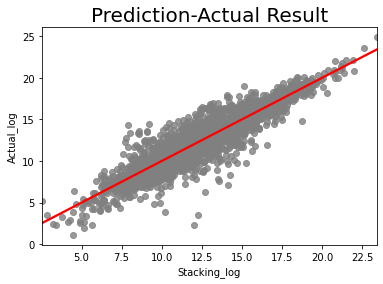

In [29]:
plot = sns.regplot(x='Stacking_log', y='Actual_log', line_kws={'color': 'red'}, scatter_kws={'color': 'grey'}, data=rslt_data)
plot.set_title("Prediction-Actual Result", fontsize = 20)
print('R2 값 : ', r2_score(rslt_data['Stacking_log'], rslt_data['Actual_log']))

<AxesSubplot:xlabel='Predict_value', ylabel='Actual_value'>

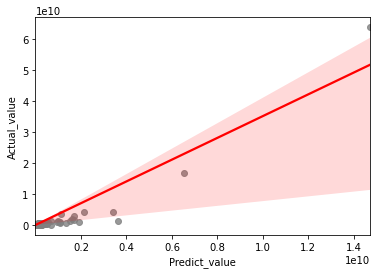

In [30]:
sns.regplot(x='Predict_value', y='Actual_value', line_kws={'color': 'red'}, scatter_kws={'color': 'grey'}, data=rslt_data)

### 3.2) 릿지 계수(Ridge Coeffiecents) 확인

In [31]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=model_data_onehot.drop('KR_TRADE_HSCD_COUNTRYCD',axis=1,inplace =False).columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1) #, ncols = 3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs.set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs.tick_params(axis="y",direction="in", pad=10)
        for label in (axs.get_xticklabels() + axs.get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs, palette='RdBu')

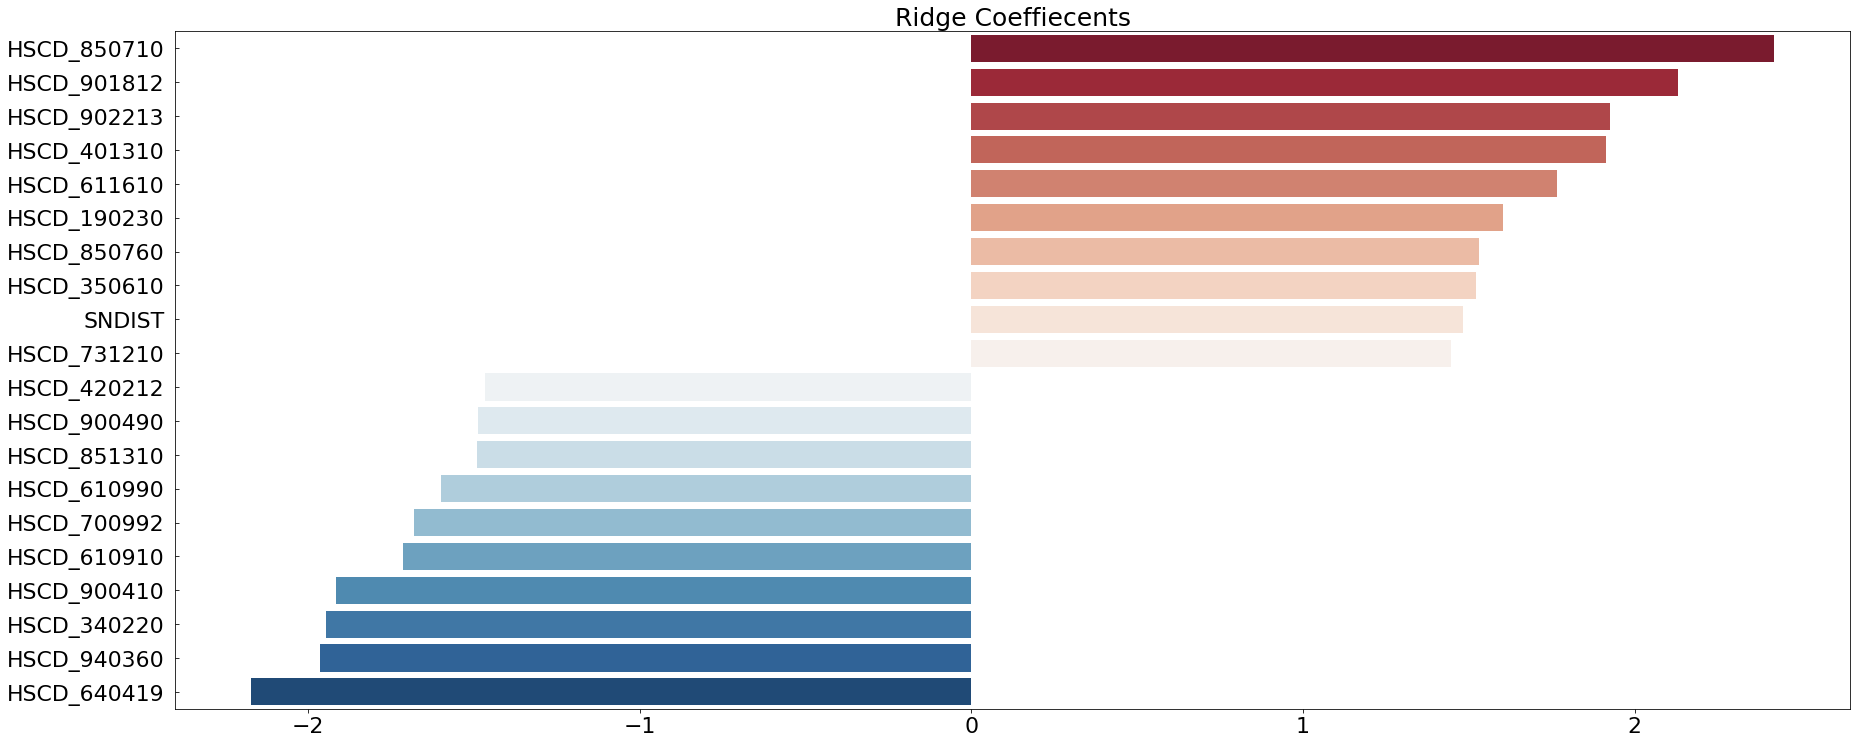

In [32]:
models = [Ridge_model]
visualize_coefficient(models)

### 3.3) 변수 중요도(Feature Importance) 확인

In [33]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=model_data_label.drop('KR_TRADE_HSCD_COUNTRYCD',axis=1,inplace =False).columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs.set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs.get_xticklabels() + axs.get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs, palette='RdBu') #RdPu
        
        # deep, muted, pastel, bright, dark, colorblind

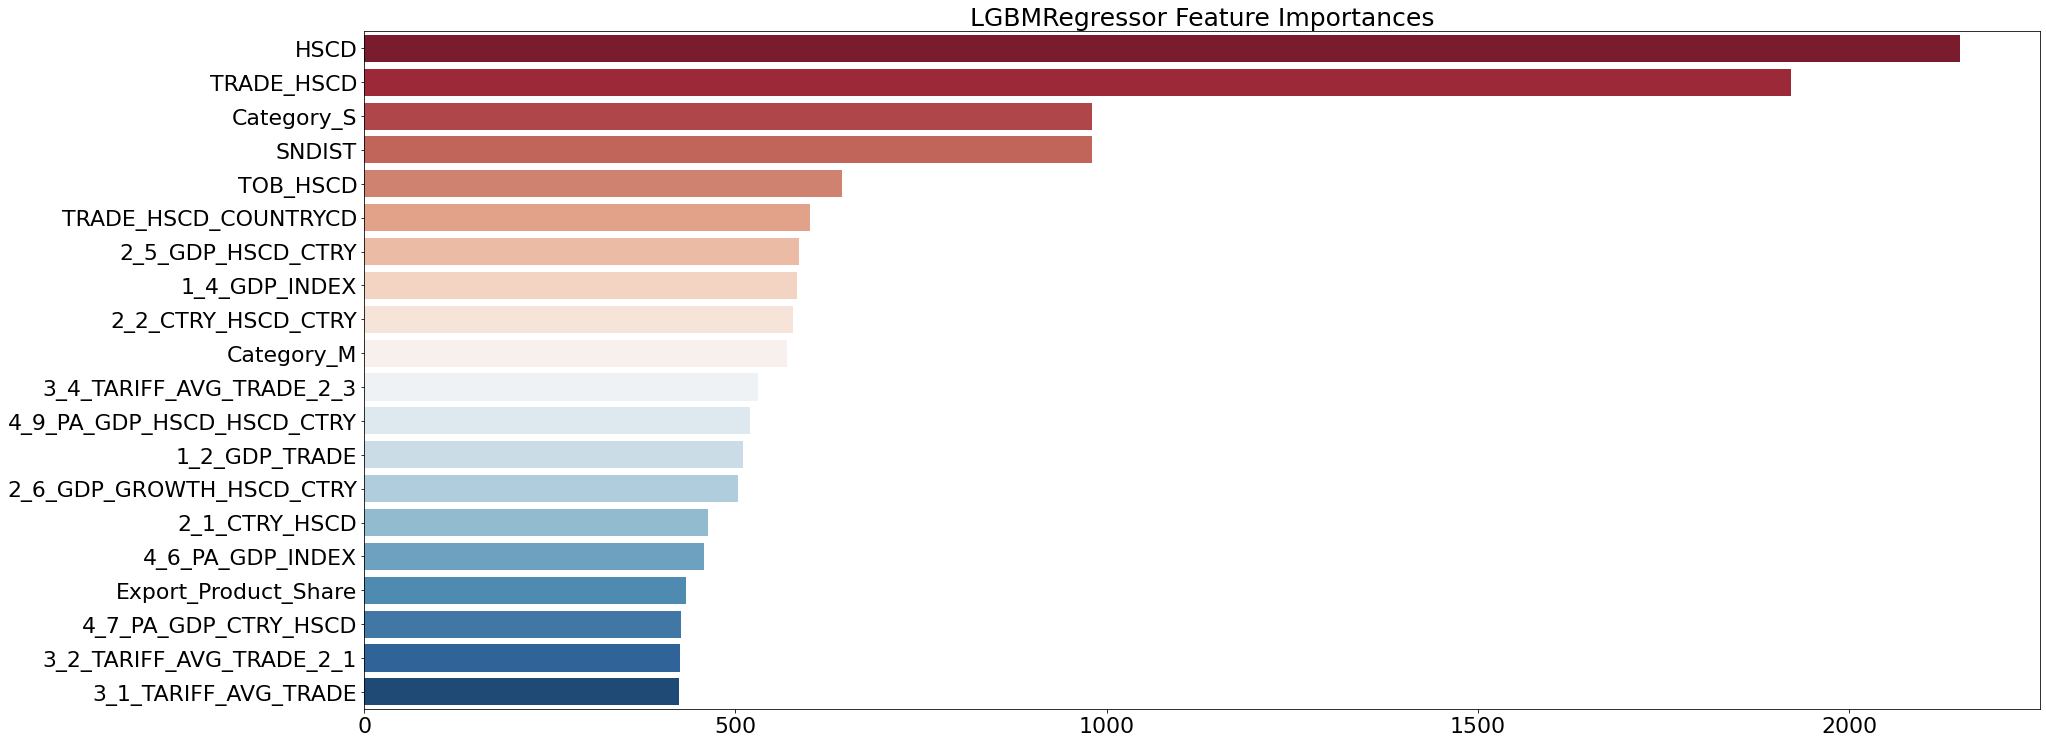

In [34]:
models = [model_lgb]
visualize_ftr_importances(models)

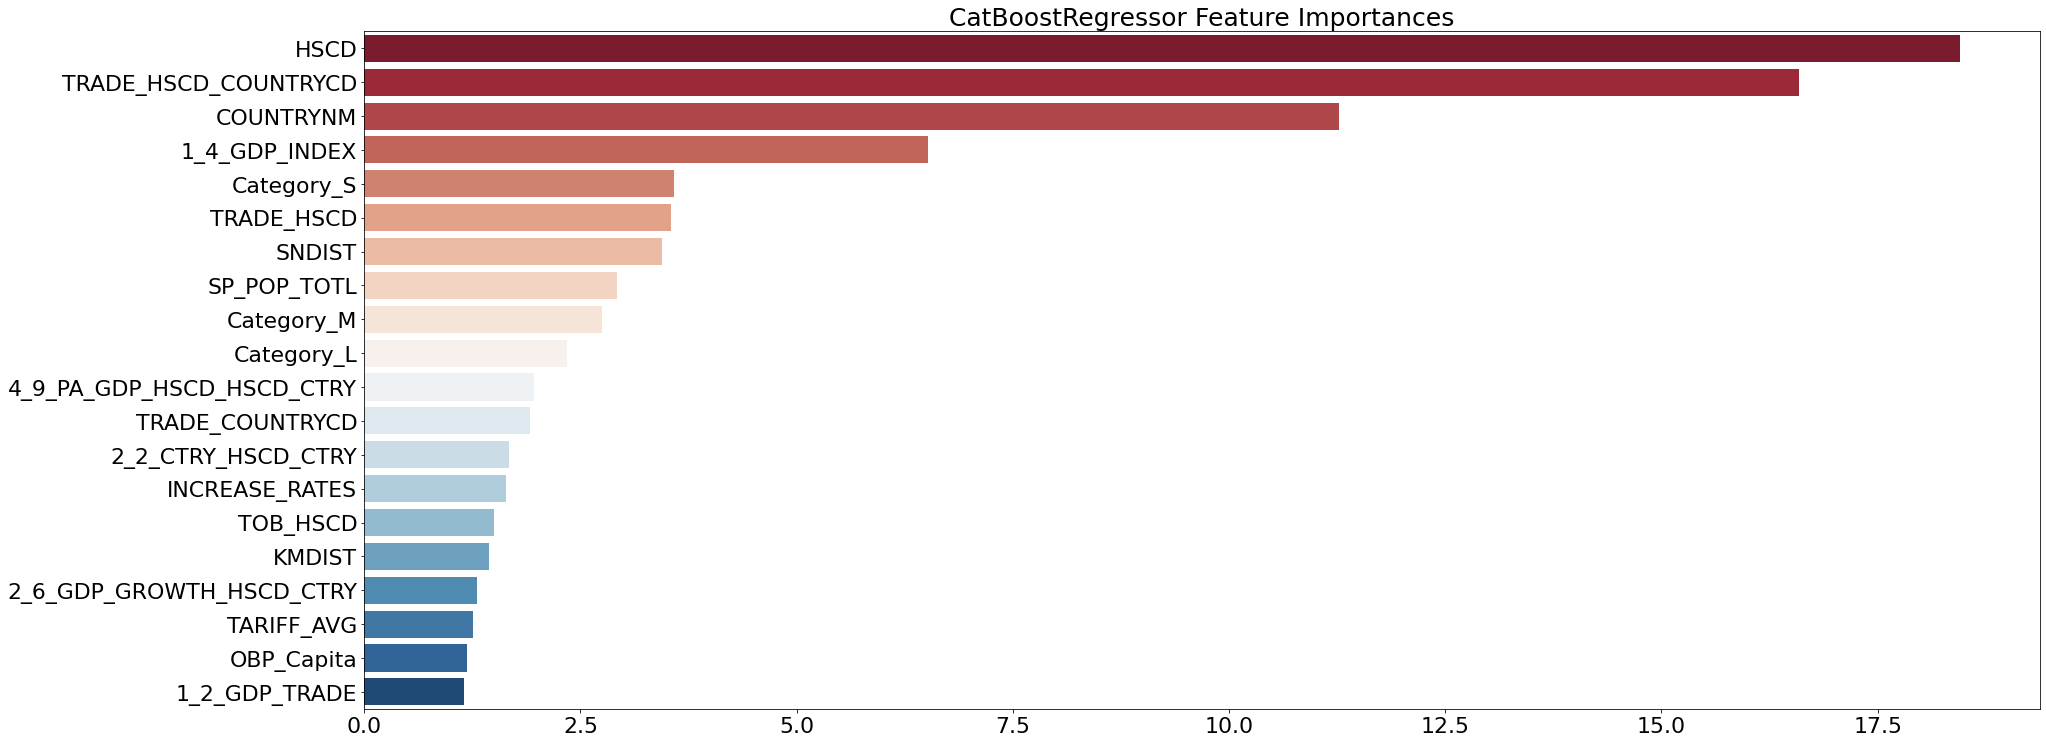

In [35]:
models = [model_cat]
visualize_ftr_importances(models)

### 3.4) XAI SHAP Value 확인

In [36]:
import lightgbm as lgb
import skimage
import shap

In [37]:
# Shap Value 사용 변수 정의
shap_value_data = model_data_label.copy()

# 파생 변수의 영향도를 확인하기 위해 기존 변수 제거
shap_value_data.drop(['HSCD','COUNTRYNM','TRADE_COUNTRYCD','TRADE_HSCD','TARIFF_AVG','SNDIST','SP_POP_TOTL','PA_NUS_FCRF',
 'IC_BUS_EASE_DFRN_DB','KMDIST', 'Category_L', 'Category_M', 'Category_S'], axis =1 ,inplace = True)

y = shap_value_data['KR_TRADE_HSCD_COUNTRYCD']
X = shap_value_data.drop('KR_TRADE_HSCD_COUNTRYCD', axis = 1)

# 데이터 분할
shap_train_x, shap_test_x, shap_train_y, shap_test_y = train_test_split(X, y, test_size = 0.2, random_state = 42) 
print(shap_train_x.shape, shap_test_x.shape, shap_train_y.shape, shap_test_y.shape)

(16661, 27) (4166, 27) (16661,) (4166,)


In [38]:
# LGBM 모델에 맞게 변환
lgb_dtrain = lgb.Dataset(data = shap_train_x, label = shap_train_y)
lgb_param = {
    "n_estimators": 1000,
    "random_state": 84, 
    'objective': 'regression'}

# 학습 및 예측
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) 
lgb_model_predict = lgb_model.predict(shap_test_x)
print("RMSE: {}".format(RMSE(lgb_model_predict, shap_test_y)))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4855
[LightGBM] [Info] Number of data points in the train set: 16661, number of used features: 27
[LightGBM] [Info] Start training from score 12.716671
RMSE: 1.9161886141978217


In [39]:
# Tree model Shap Value 확인 객체 지정
explainer = shap.TreeExplainer(lgb_model)

# Shap Values 계산
shap_values = explainer.shap_values(shap_test_x) 

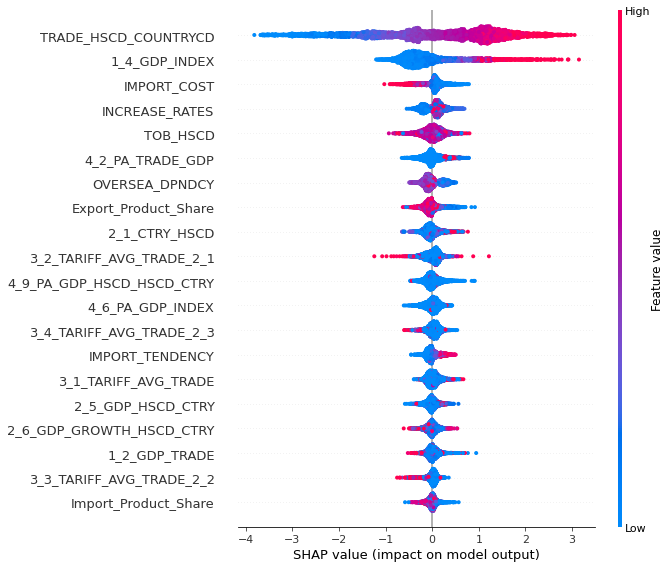

In [40]:
# 변수들에 대한 Shape value 요약, 빨간색 일수록 양의 영향을 의미
shap.summary_plot(shap_values, shap_test_x)

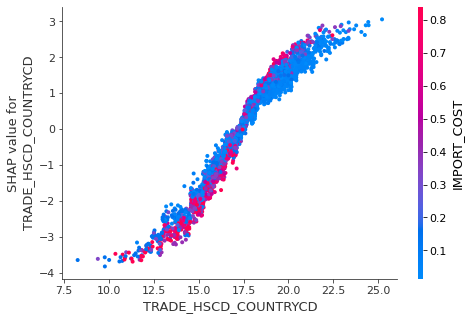

In [41]:
# 변수간 의존성을 보여주는 Shap Value
shap.dependence_plot(0, shap_values, shap_test_x) # 0, 3, 14

#### 0) TRADE_HSCD_COUNTRYCD
- 해당 국가의 특정 품목에 대한 수입액은 그 국가의 관세와 상당히 관련있음. (3_1 변수 = 해당국가품목수입액 * 관세)
- 즉, 해당 국가가 관세가 높은 품목에 대해 수입하는 경향이 높음을 의미함.

#### 2) IMPORT_COST
- 해당 국가의 특정 품목에 대한 수입액은 수입비용(IMPORT_COST)가 낮을수록 높음
- 즉, 수입비용(거리*유가)이 낮을수록 해당 국가의 특정 품목의 수입액이 높음을 의미함.

-> 이러한 데이터 분석을 통해 인사이트 도출, 수출에 관세(), 비용() 등에 영향을 받아 고려해야함.

### 3.5) 트리 맵(tree_map) 확인

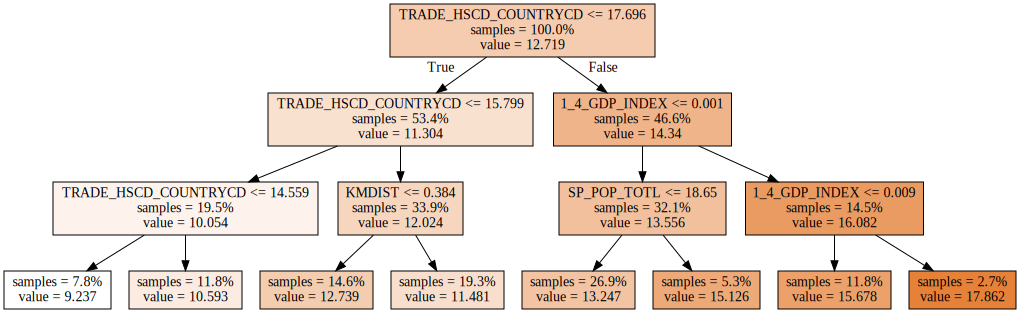

In [42]:
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

export_graphviz(tree, out_file='tree.dot',
                class_names='KR_TRADE_HSCD_COUNTRYCD',
                feature_names=model_data_label.drop('KR_TRADE_HSCD_COUNTRYCD',axis =1).columns,
                impurity=False,
                filled=True,
                proportion=True)

with open('tree.dot') as file_reader:
    dot_graph = file_reader.read()

dot = graphviz.Source(dot_graph) # dot_graph의 source 저장
dot.render(filename='tree.png') # png로 저장
dot

# 4. 활용 방안 : 수출유망품목 및 국가 추천

### 4.1) 군집화(Clustering) 전처리 - 2018년 예측 데이터

In [43]:
# 범주형 변수에 대해 object 형으로 변환
Cluster_data = predict_data.astype({'HSCD': 'str', 'COUNTRYNM' : 'str', 
                                       'Category_L' : 'str', 'Category_M' : 'str', 'Category_S' : 'str'})

# 상관계수 제거 
Cluster_data.drop(['1_3_GDP_1PER', '2_3_HSCD_HSCD_CTRY', 
                   '2_4_GDP_INDEX_HSCD_CTRY', '2_7_PER_HSCD_CTRY', '2_8_GDP_INDEX_HSCD_CTRY',
             '4_3_PA_TRADE_GDP_GROWTH', '4_4_PA_GDP_TRADE', '4_5_PA_GDP_PER', '4_8_PA_GDP_CTRY_HSCD_CTRY'], 
              axis =1 , inplace = True)  

# object형을 제외한 변수들에 대해 Minmax 정규화
numerical_feats = Cluster_data.dtypes[Cluster_data.dtypes != "object"].index.tolist()
Cluster_data[numerical_feats] = MinMaxScaler().fit_transform(Cluster_data[numerical_feats])

# 클러스터링을 위한 종속 변수 제거
Cluster_data.drop('KR_TRADE_HSCD_COUNTRYCD', axis = 1, inplace =True)
catColumnsPos = [Cluster_data.columns.get_loc(col) for col in list(Cluster_data.select_dtypes('object').columns)]

print('Categorical columns           : {}'.format(list(Cluster_data.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

# 최종 클러스터 데이터
dfMatrix = Cluster_data.to_numpy()

Categorical columns           : ['COUNTRYNM', 'HSCD', 'Category_L', 'Category_M', 'Category_S']
Categorical columns position  : [0, 1, 16, 17, 18]


### 4.2) 최적 K 탐색

In [44]:
# 최적 K 탐색 1 ~ 10 클러스터를 통해 비교
cost = []
for cluster in range(1, 11):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0) # init 변경?
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
        
# 클러스터 별 Cost를 데이터 프레임으로 변환        
df_cost = pd.DataFrame({'Cluster':range(1, 11), 'Cost':cost})
df_cost.head(10)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10


,Cluster,Cost
0,1,30768.64652
1,2,25426.23564
2,3,23710.60078
3,4,22597.37282
4,5,21583.22919
5,6,20805.03830
6,7,19887.37262
7,8,19198.40514
8,9,18514.72665
9,10,18064.22133


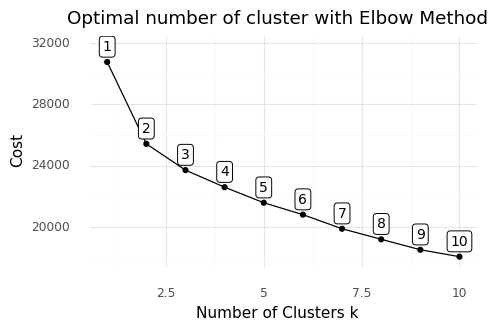

<ggplot: (120743149352)>

In [45]:
# 최적 K를 찾기 위한 Cost 감소 시각화
plotnine.options.figure_size = (5, 3)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

### 4.3) 최적 K를 통한 군집화(Clustering) 구성 및 시각화

In [46]:
# 클러스터링 학습
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 42)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([1, 2, 2, ..., 1, 2, 2], dtype=uint16)

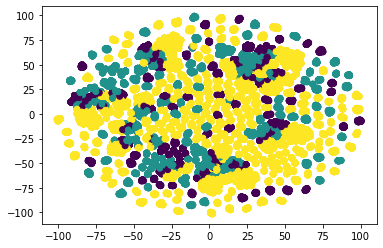

In [47]:
# 차원축소를 위한 원핫인코딩 데이터 생성
predict_data_onehot_cluster = Onehot_enc(predict_data)

# Min-Max 정규화 진행
feature_df = predict_data_onehot_cluster.drop('KR_TRADE_HSCD_COUNTRYCD', axis =1, inplace = False)
feature_df = MinMaxScaler().fit_transform(feature_df)

# 2개의 차원으로 축소
transformed = TSNE(n_components=2).fit_transform(feature_df)

# 기존 데이터프레임에 레이블 추가
Cluster_data['cluster_id'] = kprototype.labels_

# 라벨은 클러스터별 색상으로 분류
plt.scatter(transformed[:,0], transformed[:,1], c=Cluster_data['cluster_id']) 
plt.show()

- 2번 클러스터 : 12,467 , 1번 클러스터 5,239 , 0번 클러스터 3,483

### 4.4) 군집화(Clustering)에 따른 해석

In [48]:
# 데이터 복사
Cluster_data_analysis = Cluster_data.copy()

# 데이터 변경(인코딩 원복)
Cluster_data_analysis['HSCD'] = predict_data['HSCD']
Cluster_data_analysis['COUNTRYNM'] = predict_data['COUNTRYNM']
Cluster_data_analysis['Category_L'] = predict_data['Category_L']
Cluster_data_analysis['Category_M'] = predict_data['Category_M']
Cluster_data_analysis['Category_S'] = predict_data['Category_S']

# 한국으로 부터 수입한 금액 변수 병합
Cluster_data_analysis['LOG_KR_TRADE_HSCD_COUNTRYCD'] = predict_rslt['Stacking_log']
Cluster_data_analysis['KR_TRADE_HSCD_COUNTRYCD'] = predict_rslt['Predict_value']

#### 신성질 분류 데이터 중 세분류명 결합

In [49]:
# 신성질 분류 데이터 추가 및 정제
HS = pd.read_excel('./data/HSCode/HSCode.xlsx', usecols = [1,12], dtype = str) 
HS['HS CODE 10'] = HS['HS CODE 10'].str.slice_replace(start=6, stop=10)
HS.rename(columns = {'HS CODE 10' : 'HSCD','세분류명':'Detail_Category'}, inplace = True)
HS.drop_duplicates(['HSCD'], keep='first',inplace = True)

Cluster_data_analysis = Cluster_data_analysis.astype({'HSCD': 'str'})

# 군집(Cluster) 데이터 결합
Cluster_data_analysis = pd.merge(Cluster_data_analysis, HS, on='HSCD', how='left')
Cluster_data_analysis.head()

,COUNTRYNM,HSCD,IC_BUS_EASE_DFRN_DB,KMDIST,NY_GDP_MKTP_CD,PA_NUS_FCRF,SNDIST,SP_POP_TOTL,TARIFF_AVG,TRADE_COUNTRYCD,TRADE_HSCD,TRADE_HSCD_COUNTRYCD,GDP_Capita,OBP_Capita,IMPORT_COST,TOB_HSCD,Category_L,Category_M,Category_S,Export_Product_Share,Import_Product_Share,OVERSEA_DPNDCY,IMPORT_TENDENCY,INCREASE_RATES,VISA_DAYS,1_1_GDP_GROWTH_RATIO,1_2_GDP_TRADE,1_4_GDP_INDEX,2_1_CTRY_HSCD,2_2_CTRY_HSCD_CTRY,2_5_GDP_HSCD_CTRY,2_6_GDP_GROWTH_HSCD_CTRY,3_1_TARIFF_AVG_TRADE,3_2_TARIFF_AVG_TRADE_2_1,3_3_TARIFF_AVG_TRADE_2_2,3_4_TARIFF_AVG_TRADE_2_3,4_1_PA_TRADE_HSCD_CTRY,4_2_PA_TRADE_GDP,4_6_PA_GDP_INDEX,4_7_PA_GDP_CTRY_HSCD,4_9_PA_GDP_HSCD_HSCD_CTRY,cluster_id,LOG_KR_TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD,Detail_Category
0,Algeria,190590,0.07383,0.51657,0.35248,0.45077,0.18777,0.42551,0.53518,0.31834,0.58319,0.61519,0.03376,0.29752,0.71294,0.56056,소비재,직접소비재,조제식료품,0.41251,0.61193,0.51855,0.36379,0.19438,0.00000,0.48123,0.00026,0.00014,0.00671,0.00124,0.00000,0.31046,0.00014,0.00337,0.00037,0.00190,0.00000,0.00162,0.00000,0.00030,0.00000,1,9.50861,13474.27711,베이커리류
1,Australia,190590,0.85783,0.42332,0.63790,0.04755,0.76387,0.33925,0.12663,0.60538,0.58319,0.78193,0.65855,0.00761,0.03485,0.56025,소비재,직접소비재,조제식료품,0.74272,0.21285,0.46380,0.48269,0.12339,0.50000,0.66347,0.00223,0.00069,0.00118,0.01549,0.00237,0.32809,0.00045,0.00003,0.00020,0.00600,0.00430,0.00013,0.00000,0.00000,0.00000,2,16.30317,12033079.14432,베이커리류
2,Austria,190590,0.81122,0.42099,0.48204,0.03751,0.20670,0.16853,0.21441,0.56390,0.58319,0.78331,0.58954,0.01020,0.03961,0.56104,소비재,직접소비재,조제식료품,0.57502,0.35631,0.50724,0.00000,0.08176,0.50000,0.71259,0.00727,0.00079,0.00151,0.02064,0.00078,0.33173,0.00109,0.00008,0.00063,0.01452,0.00545,0.00003,0.00000,0.00000,0.00000,2,13.60042,806467.64753,베이커리류
3,Belgium,190590,0.66307,0.44585,0.50622,0.03751,0.24155,0.21070,0.21441,0.71293,0.58319,0.80016,0.54373,0.01227,0.04633,0.56391,소비재,직접소비재,조제식료품,0.57623,0.46015,0.51462,0.46559,0.08176,0.50000,0.67745,0.00936,0.00132,0.00061,0.01287,0.00143,0.33993,0.00168,0.00003,0.00039,0.02233,0.00839,0.00004,0.00000,0.00000,0.00000,2,14.18743,1450513.26866,베이커리류
4,Brazil,190590,0.29120,0.99939,0.67520,0.09276,0.62836,0.68868,0.46511,0.56241,0.58319,0.68534,0.09245,0.12685,0.59560,0.56081,소비재,직접소비재,조제식료품,0.35984,0.12775,0.49779,0.34688,1.00000,0.50000,0.03037,0.00014,0.00044,0.00153,0.00170,0.00026,0.30871,0.00055,0.00049,0.00032,0.00724,0.00017,0.00037,0.00000,0.00000,0.00000,0,12.43381,251150.69420,베이커리류


#### 작년대비 올해 수출액 증감비율

In [50]:
Cluster_data_analysis['INC_DEC_RATIO'] = (round(((predict_rslt['Stacking_log'] + 1e-05) / (np.log1p(raw_data['KR_TRADE_HSCD_COUNTRYCD'])+ 1e-05)),4) - 1) * 100

#### 데이터 프레임 정리

In [51]:
# 한국으로 부터 수입한 해당 국가별 특정 품목
def top(df, n=5, column='KR_TRADE_HSCD_COUNTRYCD'):
    return df.sort_values(by="KR_TRADE_HSCD_COUNTRYCD", ascending=False)[:n]

### 4.5) 기업 페르소나에 따른 기업 선호도 반영 분석

#### 단일 선택 시 (단일 선택시 USED_COL + 개별컬럼하여 사용) 

In [52]:
# 0. 공통 컬럼
USED_COL = ['COUNTRYNM', 'HSCD', 'Category_M', 'Category_S', 'Detail_Category', 'KR_TRADE_HSCD_COUNTRYCD']

# 1. 수출 비용 부담이 적음을 선호
TRADE_COST = ['KMDIST', 'OBP_Capita', 'IMPORT_COST', 'TARIFF_AVG', 'PA_NUS_FCRF', 'INCREASE_RATES']

# 2. 시장 규모가 큰 것을 선호
MARKET_VOL = ['SP_POP_TOTL', 'NY_GDP_MKTP_CD', 'GDP_Capita', 'TRADE_HSCD_COUNTRYCD']

# 3. 시장의 성장 가능성이 큰 것을 선호 ★
MARGET_POS = ['SP_POP_TOTL', 'NY_GDP_MKTP_CD', '1_1_GDP_GROWTH_RATIO', 'INCREASE_RATES', 'INC_DEC_RATIO']

# 4. 수출에 제약이 적은 것을 선호 ★
TRADE_REG = ['TARIFF_AVG', 'VISA_DAYS', 'IC_BUS_EASE_DFRN_DB', 'INCREASE_RATES']

# 5. 시장 진입 장벽이 낮은 것을 선호
MARKET_BAR = ['SNDIST', 'OVERSEA_DPNDCY', 'IMPORT_TENDENCY', 'Import_Product_Share', 'Export_Product_Share', 'TOB_HSCD' ]

#### 복수 선택 시

In [53]:
prefer_1_1 = USED_COL + list(set(TRADE_COST) | set(MARKET_VOL)) # 1,2
prefer_1_2 = USED_COL +list(set(TRADE_COST) | set(MARGET_POS))  # 1,3
prefer_1_3 = USED_COL +list(set(TRADE_COST) | set(TRADE_REG))   # 1.4
prefer_1_4 = USED_COL +list(set(TRADE_COST) | set(MARKET_BAR))  # 1,5

prefer_2_3 = USED_COL +list(set(MARKET_VOL) | set(MARGET_POS))  # 2,3
prefer_2_4 = USED_COL +list(set(MARKET_VOL) | set(TRADE_REG))   # 2,4
prefer_2_5 = USED_COL +list(set(MARKET_VOL) | set(MARKET_BAR))  # 2,5

prefer_3_4 = USED_COL +list(set(MARGET_POS) | set(TRADE_REG))   # 3,4
prefer_3_5 = USED_COL +list(set(MARKET_VOL) | set(MARKET_BAR))  # 3,5 

prefer_4_5 = USED_COL +list(set(TRADE_REG) | set(MARKET_BAR))   # 4,5

#### 데이터 프레임 출력

In [54]:
# 1차 필터링
mechanic = Cluster_data_analysis[Cluster_data_analysis['Category_M'] == '기계류']

# 선택 컬럼 필터링 + Top 30위 추출
Reccomend_COUNTRY_HSCD = mechanic.groupby("cluster_id").apply(top, column="KR_TRADE_HSCD_COUNTRYCD", # sorting column
                                                  n=30)[prefer_3_4] # Top n, pick column

# Ungroup 
Reccomend_COUNTRY_HSCD.reset_index(inplace = True)
Reccomend_COUNTRY_HSCD.drop('level_1', axis =1, inplace = True)

# 클러스터별 랭크지정
Reccomend_COUNTRY_HSCD['Rank'] = Reccomend_COUNTRY_HSCD.groupby('cluster_id')['KR_TRADE_HSCD_COUNTRYCD'].rank(method = 'max', ascending = False)
Reccomend_COUNTRY_HSCD['Rank'] = Reccomend_COUNTRY_HSCD['Rank'].astype('int') 
Reccomend_COUNTRY_HSCD.head()

,cluster_id,COUNTRYNM,HSCD,Category_M,Category_S,Detail_Category,KR_TRADE_HSCD_COUNTRYCD,NY_GDP_MKTP_CD,INCREASE_RATES,INC_DEC_RATIO,VISA_DAYS,TARIFF_AVG,IC_BUS_EASE_DFRN_DB,SP_POP_TOTL,1_1_GDP_GROWTH_RATIO,Rank
0,0,Mexico,840820,기계류,일반기계,내연기관 및 터빈,388568936.99419,0.61630,0.19542,43.58000,0.50000,0.00000,0.69141,0.60540,0.57362,1
1,0,Mexico,840991,기계류,일반기계,내연기관 및 터빈,263080704.66474,0.61630,0.19542,4.10000,0.50000,0.05404,0.69141,0.60540,0.57362,2
2,0,Mexico,840734,기계류,일반기계,내연기관 및 터빈,232649409.27000,0.61630,0.19542,30.24000,0.50000,0.00000,0.69141,0.60540,0.57362,3
3,0,Mexico,732690,기계류,일반기계,섬유 및 피혁가공기계,130639122.73371,0.61630,0.19542,85.06000,0.50000,0.00000,0.69141,0.60540,0.57362,4
4,0,Mexico,392690,기계류,일반기계,기타 일반기계,123306762.52707,0.61630,0.19542,93.29000,0.50000,0.30063,0.69141,0.60540,0.57362,5


In [55]:
mechanic.groupby("cluster_id").apply(top, column="KR_TRADE_HSCD_COUNTRYCD", # sorting column
                                                  n=30)[prefer_3_4] # Top n, pick column

COUNTRYNM    HSCD Category_M       Category_S  \
cluster_id                                                                   
0          19816                Mexico  840820        기계류             일반기계   
           19730                Mexico  840991        기계류             일반기계   
           19859                Mexico  840734        기계류             일반기계   
           746                  Mexico  732690        기계류             일반기계   
           2138                 Mexico  392690        기계류             일반기계   
           1255                 Mexico  731815        기계류       기계요소 및 공구류   
           15156                Mexico  850440        기계류             전기기계   
           16183                Mexico  848190        기계류       기계요소 및 공구류   
           15327                Mexico  850131        기계류             전기기계   
           19130                Mexico  841430        기계류             일반기계   
           11232                Mexico  854442        기계류             전기기계   
           16226                Mexico  848180        기계류       기계요소 및 공구류   
           14405                Mexico  851220        기계류             전기기계   
           19002                Mexico  841480        기계류             일반기계   
           11945                Mexico  853710        기계류             전기기계   
           11403                Mexico  854370        기계류             전기기계   
           18959                Mexico  841490        기계류             일반기계   
           11189                Mexico  854449        기계류             전기기계   
           15242                Mexico  850300        기계류             전기기계   
           763                  Turkey  732690        기계류             일반기계   
           16441                Mexico  847990        기계류             일반기계   
           19216                Mexico  841391        기계류             일반기계   
           574                  Mexico  761699        기계류             일반기계   
           16243                Turkey  848180        기계류       기계요소 및 공구류   
           11962                Turkey  853710        기계류             전기기계   
           15173                Turkey  850440        기계류             전기기계   
           11274                Mexico  854430        기계류             전기기계   
           19876                Turkey  840734        기계류             일반기계   
           16140                Mexico  848210        기계류       기계요소 및 공구류   
           16355                Mexico  848120        기계류       기계요소 및 공구류   
1          16447           Philippines  847990        기계류             일반기계   
           15168              Viet Nam  850440        기계류             전기기계   
           11201              Viet Nam  854449        기계류             전기기계   
           1503             Kazakhstan  730890        기계류  금속 구조물, 용기 및 무기   
           2150               Viet Nam  392690        기계류             일반기계   
           14833              Viet Nam  850760        기계류             전기기계   
           11957              Viet Nam  853710        기계류             전기기계   
           16453              Viet Nam  847990        기계류             일반기계   
           11415              Viet Nam  854370        기계류             전기기계   
           11244              Viet Nam  854442        기계류             전기기계   
           15254              Viet Nam  850300        기계류             전기기계   
           17864              Viet Nam  842890        기계류             일반기계   
           16236                 India  848180        기계류       기계요소 및 공구류   
           1265                  India  731815        기계류       기계요소 및 공구류   
           17802             Indonesia  842952        기계류             일반기계   
           18589              Viet Nam  841989        기계류             일반기계   
           19012                 India  841480        기계류             일반기계   
           18245              Viet Nam  842199        기계류             일반기계   
           17815           Philippines  842952        기계류             일반기계   
           743              Kazakhstan  732690     

#### 시각화 전처리

In [56]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [57]:
# 랭크 변수 제거
compare_data = Reccomend_COUNTRY_HSCD.drop('Rank', axis = 1)

# 정규화
numerical_feats = compare_data.dtypes[compare_data.dtypes != "object"].index.tolist()
numerical_feats.remove('cluster_id')
compare_data[numerical_feats] = MinMaxScaler().fit_transform(compare_data[numerical_feats])

# 평균 비교
compare_mean = compare_data.groupby('cluster_id').mean()

# 변수명 재정의
compare_mean.rename(columns = {'cluster_id' : '세그먼트', 'KR_TRADE_HSCD_COUNTRYCD' : '수출액', 
                                '1_1_GDP_GROWTH_RATIO' : 'GDP성장률', 'SP_POP_TOTL' : '인구',
                                 'INC_DEC_RATIO' : '수출액증감률', 'TARIFF_AVG' : '관세', 'INCREASE_RATES' : '대출금리', 
                                 'IC_BUS_EASE_DFRN_DB' : '비즈니스점수','VISA_DAYS' : '비자일수', 'NY_GDP_MKTP_CD' : 'GDP'}, inplace = True)
# 변수 명 변환
compare_mean = compare_mean.T.reset_index()
compare_mean.rename(columns = {'index' : '비교', 0 : 'A집단', 1 : 'B집단', 2 : 'C집단'}, inplace = True)

# 엑셀로 전환하기 위한 파일 저장
# compare_mean.to_csv('excel_help.csv', encoding='euc-kr',index = False)

#### 비교 시각화

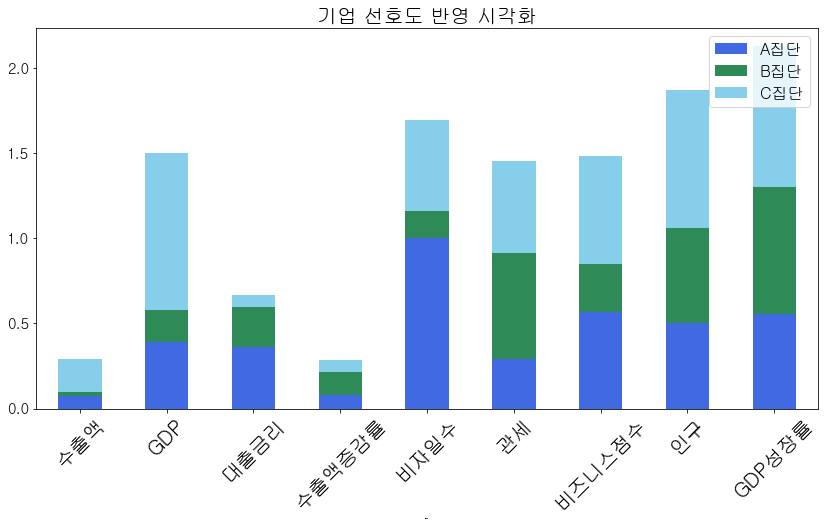

In [58]:
compare_mean.plot(x = '비교', y = ['A집단','B집단','C집단'], 
                  kind = 'bar', stacked = True,
                  figsize = (14,7), rot = 45, color = ['royalblue','seagreen', 'skyblue'])
plt.title('기업 선호도 반영 시각화', fontsize=20)
plt.legend(fontsize=16, loc='upper right')
plt.xlabel('비교변수', fontsize=0)
plt.yticks([0, 0.5, 1, 1.5, 2], fontsize=15)
plt.xticks(fontsize=20)
plt.show()

### 4.6) 클러스터링 데이터 저장(태블루 시각화용)

In [59]:
Cluster_data_analysis.to_csv('./data/[분석용]_클러스터링_데이터.csv', encoding='euc-kr', index = False)

In [60]:
Reccomend_COUNTRY_HSCD.to_csv('./data/[분석용]_클러스터링_기업선호도반영.csv', encoding='euc-kr', index = False)

- 다음 지표는 3개의 군집 별으로 이루어진 데이터로, 예측 모델에 사용한 다양한 파생변수를 기반으로 종합된 군집화 결과임.
- KR_TRADE_HSCD_COUNTRYCD을 기준으로 내림차순 한 결과로 군집 별 상위 30개씩 출력 하였음.
- 이는 각 군집별 다양한 정보를 종합적으로 비교 분석할 수 있으며, 세그멘트 별 추천을 통해 국가의 품목과 세부 카테고리를 확인할 수 있음.
- 특히 기업의 선호도를 반영한 변수를 선택하여 수출하고자 하는 기업의 내부적 상황을 보다 고려할 수 있음.
- 이를 통하여 앙상블 예측 모델을 통해 다음 연도의 한국으로부터의 수출 금액을 예측하고 사용자는 사전적 행동을 개시할 수 있음.